In [1]:
import pandas as pd
import datetime
from collections import Counter
import os
import shutil

In [2]:
final_financial_data_directory = 'final_financial_data'
final_financial_data_in_date_range_directory = 'final_financial_data_in_date_range'
final_financial_data_processed_17_variables_directory = 'final_financial_data_processed_17_variables'
final_financial_data_processed_100_variables_directory = 'final_financial_data_processed_100_variables'
final_financial_data_processed_17_variables_5years_directory = 'final_financial_data_processed_17_variables_5years'

In [34]:
eligible_companies = pd.read_csv('companies_eligible_to_financial_dataset_2024-04-19_14-47-55.csv')
eligible_companies.head()

,Unnamed: 0,cik,company,label,ticker,gurufocus-company-name,gurufocus-stockid,filing_date,cik-equal-gurufocus-cik,first_match
0,0,1800,ABBOTT LABORATORIES,False,ABT,Abbott Laboratories,US066X,2021-02-19,True,NaN
1,1,2488,ADVANCED MICRO DEVICES INC,False,AMD,Advanced Micro Devices Inc,US022E,2021-01-29,True,NaN
2,2,2491,"BALLY TECHNOLOGIES, INC.",False,BYI,Bally Technologies Inc (Delisted),US06R5,2014-08-29,True,NaN
3,3,2601,AEROFLEX INC,False,ARXX,Aeroflex Inc (Delisted),US026H,2006-09-13,True,NaN
4,4,2969,AIR PRODUCTS & CHEMICALS INC /DE/,False,APD,Air Products & Chemicals Inc,US06DU,2021-11-18,True,NaN


In [35]:
eligible_companies['label'].value_counts()

label
False    5291
True      126
Name: count, dtype: int64

In [36]:
final_eligible_companies = eligible_companies.copy()

In [133]:
def drop_columns_after_ttm_or_preliminary(df):
    try:
        try:
            ttm_index = df.columns.get_loc('TTM')
            df = df.iloc[:, :ttm_index]
            return df
        except:
            pass
            
        try:
            ttm_preliminary_string = 'TTM  Preliminary'
            ttm_index = df.columns.get_loc(ttm_preliminary_string)
            df = df.iloc[:, :ttm_index]
            return df
        except:
            print(f'No \'TTM  Preliminary\' column in {filename}')
            
        try:
            preliminary_string = 'Preliminary'
            preliminary_index = None
            for i, s in enumerate(df.columns):
                if preliminary_string in s:
                    preliminary_index = i
                    break
                    
            df = df.iloc[:, :preliminary_index + 1]
            last_column_name = df.columns[-1]
            split_date = last_column_name.split(' ')
            updated_col_name = f'{split_date[0]} {split_date[1]}'
            
            df.rename(columns={last_column_name: updated_col_name}, inplace=True)
            
            print(f'No TTM but found Preliminary in {filename}')
        except:
            print(f'No Preliminary column in {filename}')
        
    except Exception as ex:
        print(f'Ex: {ex}, filename: {filename}')
    
    return df

def clean_date_index(df):
    for index in df.index:
        split_date = index.split(' ')
        month, year = split_date[0], int(split_date[1])
        
        if 0 <= year <= 9:
            year = f'200{year}'
        elif 10 <= year <= 24:
            year = f'20{year}'
        elif year > 24:
            year = f'19{year}'
            
        df.rename(index={index: f'{month} {year}'}, inplace=True)
    return df

In [134]:
def set_date_difference(final_eligible_companies):

    for index, row in final_eligible_companies.iterrows():
        try:
            cik = row['cik']
            gurufocus_stockid = row['gurufocus-stockid']
            ticker = row['ticker']
            filing_date = row['filing_date']
                
            filepath = f'{final_financial_data_directory}/{cik}-{gurufocus_stockid}_{ticker}.csv'
                
            df = pd.read_csv(filepath)
            
            df = drop_columns_after_ttm_or_preliminary(df)
            
            last_column_name = df.columns[-1]
            split_date = last_column_name.split(' ')
            month, year = split_date[0], int(split_date[1])
            
            if 0 <= year <= 9:
                year = f'200{year}'
            elif 10 <= year <= 24:
                year = f'20{year}'
            elif year > 24:
                year = f'19{year}'
                
            gurufocus_last_data_date = datetime.datetime.strptime(f'{month} {year}', '%b %Y')
            
            filing_date = filing_date[:7]
            filing_date = datetime.datetime.strptime(f'{filing_date}', '%Y-%m')
    
            difference_in_months = int((gurufocus_last_data_date - filing_date).days / 30)
            
            final_eligible_companies.loc[final_eligible_companies['cik'] == cik, 'difference_in_months'] = difference_in_months
        
        except Exception as ex:
            print(f'Ex: {ex}, filename: {filename}')
        
    return final_eligible_companies

In [41]:
final_eligible_companies = set_date_difference(final_eligible_companies)

Ex: invalid literal for int() with base 10: 'Period', filename: 1000180-US05DT_SNDK.csv


In [42]:
counts_df = final_eligible_companies['difference_in_months'].value_counts()
# set column names
counts_df = counts_df.reset_index()
counts_df.columns = ['difference_in_months', 'count']
counts_df.head()

,difference_in_months,count
0,-3.0,1398
1,34.0,1190
2,-2.0,825
3,33.0,676
4,22.0,325


In [43]:
def get_companies_within_date_range(final_eligible_companies):
    mask = (final_eligible_companies['difference_in_months'] > -12) & (final_eligible_companies['difference_in_months'] < 36)
    eligible_companies_in_eligible_range = final_eligible_companies[mask]
    eligible_companies_in_eligible_range['difference_in_months'] = eligible_companies_in_eligible_range['difference_in_months'].astype(int)
    return eligible_companies_in_eligible_range

def drop_unused_columns(final_eligible_companies):
    final_eligible_companies.drop(columns=['cik-equal-gurufocus-cik', 'first_match'], inplace=True)
    return final_eligible_companies

#### Processing I

In [44]:
final_eligible_companies = get_companies_within_date_range(final_eligible_companies)
final_eligible_companies = drop_unused_columns(final_eligible_companies)

print(len(final_eligible_companies))
final_eligible_companies['label'].value_counts(normalize=True)

5078


C:\Users\grzeg\AppData\Local\Temp\ipykernel_30780\3847550151.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eligible_companies_in_eligible_range['difference_in_months'] = eligible_companies_in_eligible_range['difference_in_months'].astype(int)
C:\Users\grzeg\AppData\Local\Temp\ipykernel_30780\3847550151.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_eligible_companies.drop(columns=['cik-equal-gurufocus-cik', 'first_match'], inplace=True)


label
False    0.976959
True     0.023041
Name: proportion, dtype: float64

In [45]:
final_eligible_companies.to_csv('eligible_companies_in_eligible_range.csv', index=False)

In [46]:
for index, row in final_eligible_companies.iterrows():
    cik = row['cik']
    gurufocus_stockid = row['gurufocus-stockid']
    ticker = row['ticker']
    filing_date = row['filing_date']
    
    filepath = f'{final_financial_data_directory}/{cik}-{gurufocus_stockid}_{ticker}.csv'
        
    shutil.copy(filepath, f'./{final_financial_data_in_date_range_directory}/{cik}-{gurufocus_stockid}_{ticker}.csv')

#### Processing II - creating set of files with 17 variables

In [160]:
final_eligible_companies = pd.read_csv('eligible_companies_in_eligible_range.csv')
len(final_eligible_companies)

5078

In [161]:
with open('chosen_variables.txt', 'r') as file:
    chosen_variables = file.read().splitlines()
    
with open('most_common_variables.txt', 'r') as file:
    most_common_variables = file.read().splitlines()

In [162]:
def delete_duplicated_rows(df):
    df.drop(df.index[df.iloc[:, 0].duplicated(keep=False)], inplace=True)
    return df

def has_dataframe_enough_variables(df, variables, threshold):
    csv_variable = df.iloc[:, 0].tolist()
    lacking_variables = []
    for variable in variables:
        if variable not in csv_variable:
            lacking_variables.append(variable)
            
    if len(lacking_variables) <= threshold:
        return True, lacking_variables
    else:
        return False, lacking_variables
    
def enrich_filename_with_label(filename, label):
    filename = filename.replace('.csv', '')
    filename = f'{filename}_{label}.csv'
    return filename

In [163]:
max_lacking_variables_threshold_chosen_variables = 3
missing_values_array = []

for filename in os.listdir(final_financial_data_in_date_range_directory):
    try:
        cik = int(filename.split('-')[0])
        df = pd.read_csv(f'{final_financial_data_in_date_range_directory}/{filename}')
        
        df.drop(df.columns[0], axis=1, inplace=True)
        
        df = drop_columns_after_ttm_or_preliminary(df)
        
        df = delete_duplicated_rows(df)
        
        has_enough_variables, lacking_variables = has_dataframe_enough_variables(df, chosen_variables, max_lacking_variables_threshold_chosen_variables)
        if has_enough_variables is False:
            final_eligible_companies.loc[final_eligible_companies['cik'] == cik, 'has_enough_variables'] = False
            continue
        
        df.set_index(df.columns[0], inplace=True)
                
        df = df[df.index.isin(chosen_variables)]
        
        df = df.T
        df = df.replace('-', pd.NA)
        df = df.replace('', pd.NA)
        
        df.fillna(method='bfill', inplace=True)
        df.fillna(method='ffill', inplace=True)
        df.fillna(0, inplace=True)
        
        # insert missing variables as whole columns with 0
        if len(lacking_variables) > 0:
            for variable in lacking_variables:
                df[variable] = 0
                
        df = clean_date_index(df)
        
        df = df.reindex(sorted(df.columns), axis=1)
        
        label = final_eligible_companies.loc[final_eligible_companies['cik'] == cik]['label'].values[0]
        
        df.to_csv(f'{final_financial_data_processed_17_variables_directory}/{enrich_filename_with_label(filename, label)}', index=True, index_label='Fiscal Period')
        
        final_eligible_companies.loc[final_eligible_companies['cik'] == cik, 'has_enough_variables'] = True
        
        missing_value = df.isnull().sum().sum()
        if missing_value > 0:
            print(f'Missing value in {filename}')
        missing_values_array.append(missing_value)
        
    except Exception as ex:
        print(f'Ex: {ex}, filename: {filename}')   

In [164]:
final_eligible_companies['has_enough_variables'].value_counts()

has_enough_variables
True     3777
False    1301
Name: count, dtype: int64

In [165]:
final_eligible_companies_with_enough_variables = final_eligible_companies[final_eligible_companies['has_enough_variables'] == True]

In [166]:
final_eligible_companies_with_enough_variables.drop(columns=['has_enough_variables'], inplace=True)

C:\Users\grzeg\AppData\Local\Temp\ipykernel_30780\3149027593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_eligible_companies_with_enough_variables.drop(columns=['has_enough_variables'], inplace=True)


In [167]:
final_eligible_companies_with_enough_variables.to_csv('eligible_companies_in_eligible_range_with_enough_variables.csv', index=False)

In [168]:
final_eligible_companies_with_enough_variables['label'].value_counts(normalize=True)

label
False    0.97776
True     0.02224
Name: proportion, dtype: float64

In [169]:
missing_values_counts = Counter(missing_values_array)
missing_values_counts

Counter({0: 3777})

In [100]:
csv_lengths = []
for filename in os.listdir(final_financial_data_processed_17_variables_directory):
    df = pd.read_csv(f'{final_financial_data_processed_17_variables_directory}/{filename}')
    
    csv_lengths.append(len(df))

(array([3.000e+00, 1.400e+01, 3.800e+01, 7.600e+01, 1.200e+02, 1.820e+02,
        1.750e+02, 0.000e+00, 1.940e+02, 1.960e+02, 1.790e+02, 2.090e+02,
        2.090e+02, 1.750e+02, 0.000e+00, 1.460e+02, 4.770e+02, 1.211e+03,
        3.200e+01, 1.800e+01, 3.500e+01, 7.300e+01, 0.000e+00, 5.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 6.000e+00, 1.000e+00]),
 array([ 1.        ,  1.86666667,  2.73333333,  3.6       ,  4.46666667,
         5.33333333,  6.2       ,  7.06666667,  7.93333333,  8.8       ,
         9.66666667, 10.53333333, 11.4       , 12.26666667, 13.13333333,
        14.        , 14.86666667, 15.73333333, 16.6       , 17.46666667,
        18.33333333, 19.2       , 20.06666667, 20.93333333, 21.8       ,
        22.66666667, 23.53333333, 24.4       , 25.26666667, 26.13333333,
        27.        ]),
 <BarContainer object of 30 artists>)

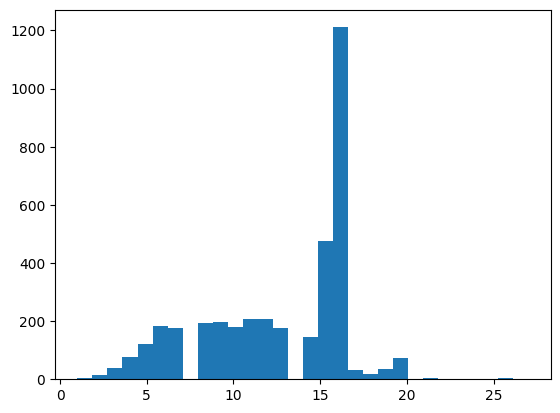

In [101]:
import matplotlib.pyplot as plt

plt.hist(csv_lengths, bins=30)

In [122]:
csv_lengths_counter = Counter(csv_lengths)
csv_lengths_counter

Counter({16: 1211,
         15: 477,
         12: 209,
         11: 209,
         9: 196,
         8: 194,
         6: 182,
         10: 179,
         13: 175,
         7: 175,
         14: 146,
         5: 120,
         4: 76,
         20: 73,
         3: 38,
         19: 35,
         17: 32,
         18: 18,
         2: 14,
         26: 6,
         21: 5,
         1: 3,
         22: 1,
         27: 1,
         25: 1,
         23: 1})

#### csv data extra validation

In [170]:
for filename in os.listdir(final_financial_data_processed_17_variables_directory):
    df = pd.read_csv(f'{final_financial_data_processed_17_variables_directory}/{filename}', index_col='Fiscal Period')
    
    column_headers = df.columns.tolist()
    
    if len(column_headers) != len(chosen_variables):
        print(f'Error in {filename}')

##### Getting variables within x years from bankruptcy

In [123]:
ecl_dataset = pd.read_csv('ECL_with_ticker_2024-04-19_14-35-21.csv')

C:\Users\grzeg\AppData\Local\Temp\ipykernel_30780\1756588558.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  ecl_dataset = pd.read_csv('ECL_with_ticker_2024-04-19_14-35-21.csv')


In [124]:
ecl_dataset_grouped = ecl_dataset.groupby('cik').agg({'bankruptcy_date_1': 'first', 'ticker': 'first', 'label': 'last', 'cik-equal-gurufocus-cik': 'last', 'filing_date': 'last'}).reset_index()
ecl_dataset_grouped['is_bankruptcy_date_filled'] = ecl_dataset_grouped['bankruptcy_date_1'].notnull()
ecl_dataset_grouped['is_bankruptcy_date_filled'].value_counts()

is_bankruptcy_date_filled
False    8252
True      891
Name: count, dtype: int64

In [125]:
ecl_dataset_grouped_eligible = ecl_dataset_grouped[ecl_dataset_grouped['cik-equal-gurufocus-cik'] == True]
len(ecl_dataset_grouped_eligible)

5417

In [175]:
index_to_have_minimal_years_threshold = 5
eligible_companies_with_minimal_years_count = 0

for filename in os.listdir(final_financial_data_processed_17_variables_directory):
    try:
        df = pd.read_csv(f'{final_financial_data_processed_17_variables_directory}/{filename}', index_col='Fiscal Period')
        
        cik = int(filename.split('-')[0])
        label = bool(filename.split('_')[2].split('.')[0])
        
        last_datetime = ecl_dataset_grouped_eligible.loc[ecl_dataset_grouped_eligible['cik'] == cik]['bankruptcy_date_1'].values[0]
        
        if last_datetime is not None: # shorten
            last_datetime = last_datetime
        else:
            last_datetime = ecl_dataset_grouped_eligible.loc[ecl_dataset_grouped_eligible['cik'] == cik]['filing_date'].values[0]
            
        last_datetime = last_datetime[:7]
        last_datetime = datetime.datetime.strptime(last_datetime, '%Y-%m')
        
        indexes_as_datetime = []
        for index in df.index:
            indexes_as_datetime.append(datetime.datetime.strptime(f'{index}', '%b %Y'))
            
        for i, date in reversed(list(enumerate(indexes_as_datetime))):
            if date <= last_datetime:
                corresponding_last_date = date
                
                if i >= index_to_have_minimal_years_threshold - 1:
                    # drop rows after i
                    # df = df.iloc[i-index_to_have_minimal_years_threshold+1:i + 1]
                    eligible_companies_with_minimal_years_count += 1
                    # df.to_csv(f'{final_financial_data_processed_17_variables_5years_directory}/{filename}', index=True, index_label='Fiscal Period')
                    ecl_dataset_grouped_eligible.loc[ecl_dataset_grouped_eligible['cik'] == cik, 'has_minimal_years'] = True
                break
                
    except Exception as ex:
        print(f'Ex: {ex}, filename: {filename}')

C:\Users\grzeg\AppData\Local\Temp\ipykernel_30780\389885495.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecl_dataset_grouped_eligible.loc[ecl_dataset_grouped_eligible['cik'] == cik, 'has_minimal_years'] = True


In [172]:
eligible_companies_with_minimal_years_count

3420

In [178]:
ecl_dataset_grouped_eligible_with_minimal_years = ecl_dataset_grouped_eligible[ecl_dataset_grouped_eligible['has_minimal_years'] == True]

len(ecl_dataset_grouped_eligible_with_minimal_years)

3420

# Dataset for 17 variables exists, with data from 5 years - could be used for training model

In [ ]:
# TODO later: save with filename to report - match by bankruptcy or filing date !!!
# TODO: plot labels distribution
ecl_dataset_grouped_eligible_with_minimal_years.to_csv('ecl_dataset_grouped_eligible_with_minimal_years.csv', index=False)

In [25]:
bankrupt_companies_with_17_variables_5_years = pd.DataFrame()

for i, filename in enumerate(os.listdir(final_financial_data_processed_17_variables_5years_directory)):
    try:
        df = pd.read_csv(f'{final_financial_data_processed_17_variables_5years_directory}/{filename}', index_col='Fiscal Period')
        
        filename_without_extension = filename.replace('.csv', '')
        
        label = filename_without_extension.split('_')[-1]

        mapping = {'True': True, 'False': False}
        label = mapping[label]
        
        df.reset_index(inplace=True)
        df.insert(loc=0, column='cik', value=int(filename.split('-')[0]))
        df.insert(loc=1, column='ticker', value=filename.split('_')[1])
        df.insert(loc=2, column='label', value=label)

        bankrupt_companies_with_17_variables_5_years = pd.concat([bankrupt_companies_with_17_variables_5_years, df])
        
    except Exception as ex:
        print(f'Ex: {ex}, filename: {filename}')

bankrupt_companies_with_17_variables_5_years.sort_values(by=['cik', 'Fiscal Period'], inplace=True)
bankrupt_companies_with_17_variables_5_years.to_csv('bankrupt_companies_with_17_variables_5_years.csv', index=False)

In [26]:
bankrupt_companies_with_17_variables_5_years.head(20)

,cik,ticker,label,Fiscal Period,Cost of Goods Sold,"Depreciation, Depletion and Amortization",EBIT,EBITDA,Gross Profit,Long-Term Debt,...,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
0,1800,ABT,False,Dec 2016,9094.0,1353.0,1844.0,3197.0,11759.0,20681.0,...,1400.0,25565.0,20853.0,52666.0,26776.0,6660.0,2434.0,31949.0,8733.0,5054.0
1,1800,ABT,False,Dec 2017,12409.0,3021.0,3135.0,6156.0,14981.0,27210.0,...,477.0,23978.0,27390.0,76250.0,20147.0,8912.0,3601.0,45152.0,13417.0,6916.0
2,1800,ABT,False,Dec 2018,12706.0,3278.0,3699.0,6977.0,17872.0,19359.0,...,2368.0,24560.0,30578.0,67173.0,14632.0,9012.0,3796.0,36451.0,14222.0,6750.0
3,1800,ABT,False,Dec 2019,13231.0,3014.0,4747.0,7761.0,18673.0,16661.0,...,3687.0,25847.0,31904.0,67887.0,15667.0,10863.0,4316.0,36586.0,14141.0,7211.0
4,1800,ABT,False,Dec 2020,15003.0,3327.0,5514.0,8841.0,19605.0,18527.0,...,4495.0,27627.0,34608.0,72548.0,20441.0,11907.0,5012.0,39545.0,14248.0,8281.0
0,2488,AMD,False,Dec 2016,3316.0,133.0,-293.0,-160.0,1003.0,1435.0,...,-498.0,-7803.0,4319.0,3321.0,2530.0,1346.0,751.0,2905.0,1386.0,343.0
1,2488,AMD,False,Dec 2017,3466.0,144.0,118.0,262.0,1787.0,1325.0,...,-33.0,-7775.0,5253.0,3552.0,2634.0,1513.0,694.0,2956.0,1660.0,487.0
2,2488,AMD,False,Dec 2018,4028.0,170.0,451.0,621.0,2447.0,1114.0,...,337.0,-7436.0,6475.0,4556.0,3540.0,1984.0,845.0,3290.0,1996.0,1269.0
3,2488,AMD,False,Dec 2019,3863.0,258.0,466.0,724.0,2868.0,486.0,...,341.0,-7095.0,6731.0,6028.0,4597.0,2359.0,982.0,3201.0,2237.0,1879.0
4,2488,AMD,False,Dec 2020,5416.0,354.0,1322.0,1676.0,4347.0,330.0,...,2490.0,-4605.0,9763.0,8962.0,6143.0,2417.0,1399.0,3125.0,2978.0,2076.0


In [88]:
bankrupt_companies_with_17_variables_5_years = pd.read_csv('bankrupt_companies_with_17_variables_5_years.csv')

bankrupt_companies_with_17_variables_5_years_grouped = bankrupt_companies_with_17_variables_5_years.groupby('cik').agg({'label': 'first'}).reset_index()

bankrupt_companies_with_17_variables_5_years_grouped['label'].value_counts(normalize=True)

label
False    0.97924
True     0.02076
Name: proportion, dtype: float64

In [89]:
number_of_companies = len(bankrupt_companies_with_17_variables_5_years_grouped)
number_of_companies

3420

In [90]:
train_ratio = 0.8
validation_ratio = 0.05
test_ratio = 0.15

#### sandbox for reading csv by model & splitting data

In [91]:
bankrupt_companies_with_17_variables_5_years_grouped_false = bankrupt_companies_with_17_variables_5_years_grouped[bankrupt_companies_with_17_variables_5_years_grouped['label'] == False]

false_len = len(bankrupt_companies_with_17_variables_5_years_grouped_false)

bankrupt_companies_with_17_variables_5_years_grouped_true = bankrupt_companies_with_17_variables_5_years_grouped[bankrupt_companies_with_17_variables_5_years_grouped['label'] == True]

true_len = len(bankrupt_companies_with_17_variables_5_years_grouped_true)

train_set = pd.concat([bankrupt_companies_with_17_variables_5_years_grouped_false[:int(train_ratio * false_len)], bankrupt_companies_with_17_variables_5_years_grouped_true[:int(train_ratio * true_len)]])

validation_set = pd.concat([bankrupt_companies_with_17_variables_5_years_grouped_false[int(train_ratio * false_len):int((train_ratio + validation_ratio) * false_len)], bankrupt_companies_with_17_variables_5_years_grouped_true[int(train_ratio * true_len):int((train_ratio + validation_ratio) * true_len)]])

test_set = pd.concat([bankrupt_companies_with_17_variables_5_years_grouped_false[int((train_ratio + validation_ratio) * false_len):], bankrupt_companies_with_17_variables_5_years_grouped_true[int((train_ratio + validation_ratio) * true_len):]])

len(train_set), len(validation_set), len(test_set)

(2735, 171, 514)

In [92]:
train_set.head()

,cik,label
0,1800,False
1,2488,False
2,2491,False
3,2969,False
4,3153,False


In [93]:
train_set['label'].value_counts(normalize=True)

label
False    0.979525
True     0.020475
Name: proportion, dtype: float64

In [94]:
train_set['subset'] = 'train'
validation_set['subset'] = 'validation'
test_set['subset'] = 'test'

train_set.drop(columns=['label'], inplace=True)
validation_set.drop(columns=['label'], inplace=True)
test_set.drop(columns=['label'], inplace=True)

subsets = pd.concat([train_set, validation_set, test_set])

subsets = subsets.sample(frac=1).reset_index(drop=True)

final_dataset_with_17_variables_5_years_split = subsets.merge(bankrupt_companies_with_17_variables_5_years, on='cik', how='left')

final_dataset_with_17_variables_5_years_split.to_csv('bankrupt_companies_with_17_variables_5_years.csv', index=False)

final_dataset_with_17_variables_5_years_split.head()

,cik,subset,ticker,label,Fiscal Period,Cost of Goods Sold,"Depreciation, Depletion and Amortization",EBIT,EBITDA,Gross Profit,...,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
0,1045810,train,NVDA,False,Jan 2017,2847.0,187.0,1963.0,2150.0,4063.0,...,1666.0,6108.0,6910.0,9841.0,8536.0,1819.0,794.0,4079.0,2126.0,826.0
1,1045810,train,NVDA,False,Jan 2018,3892.0,199.0,3257.0,3456.0,5822.0,...,3047.0,8787.0,9714.0,11241.0,9255.0,1153.0,796.0,3770.0,2612.0,1265.0
2,1045810,train,NVDA,False,Jan 2019,4545.0,262.0,3954.0,4216.0,7171.0,...,4141.0,12565.0,11716.0,13292.0,10557.0,1329.0,1575.0,3950.0,3367.0,1424.0
3,1045810,train,NVDA,False,Jan 2020,4150.0,381.0,3022.0,3403.0,6768.0,...,2796.0,14971.0,10918.0,17315.0,13690.0,1784.0,979.0,5111.0,3922.0,1657.0
4,1045810,train,NVDA,False,Jan 2021,6279.0,1098.0,4593.0,5691.0,10396.0,...,4332.0,18908.0,16675.0,28791.0,16055.0,3925.0,1826.0,11898.0,5864.0,2429.0


In [95]:
final_dataset_with_17_variables_5_years_split['subset'].value_counts(normalize=True)

subset
train         0.799708
test          0.150292
validation    0.050000
Name: proportion, dtype: float64

In [96]:
train_set_grouped = final_dataset_with_17_variables_5_years_split[final_dataset_with_17_variables_5_years_split['subset'] == 'train']
train_set_grouped['label'].value_counts(normalize=True)

label
False    0.979525
True     0.020475
Name: proportion, dtype: float64

#### Processing II - creating set of files with 100 variables

In [ ]:
max_lacking_variables_threshold_most_common_variables = 12